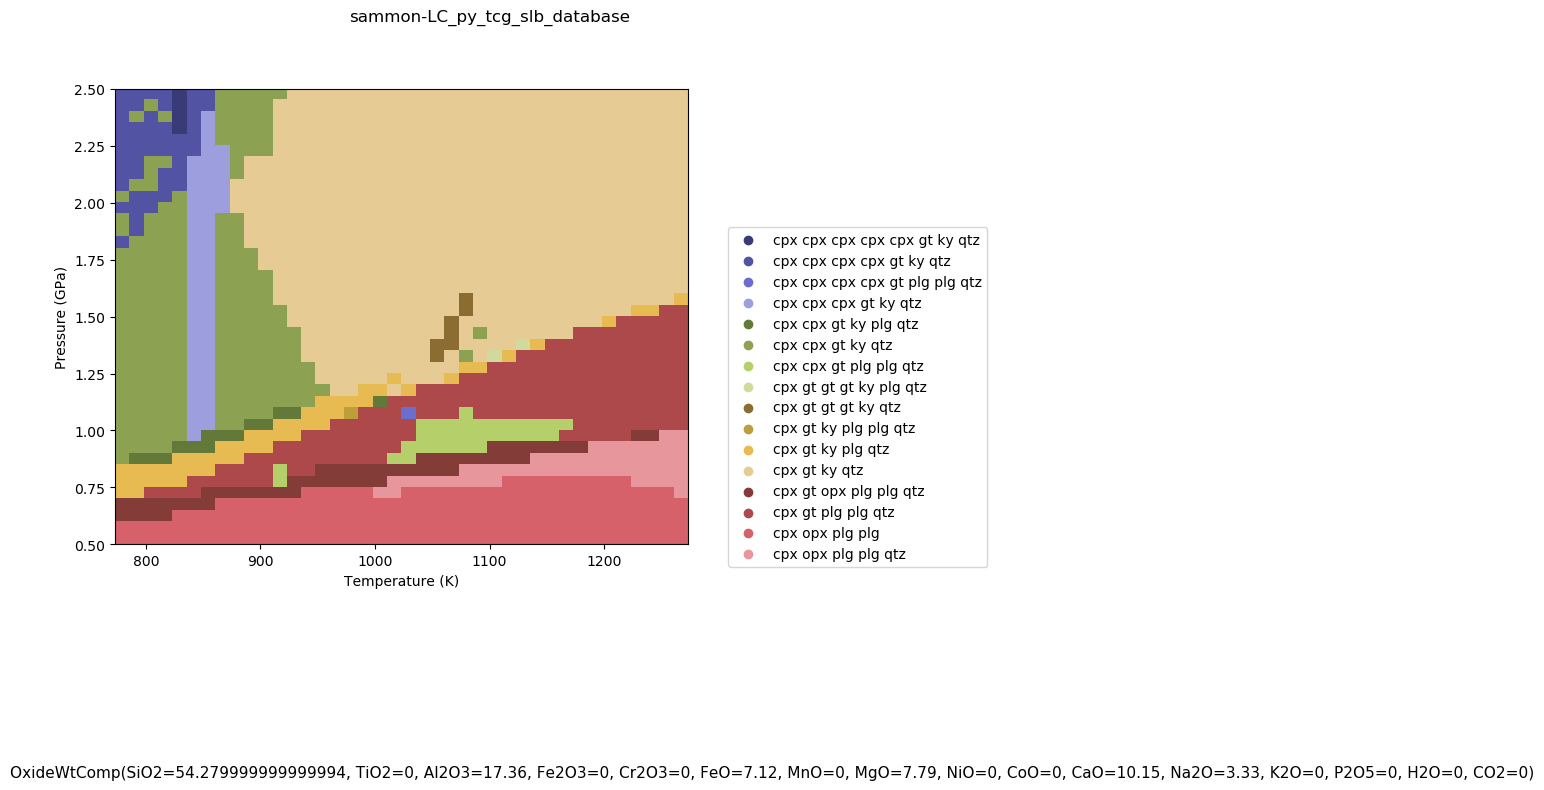

In [3]:
import equilibrate_phase_diagram
from thermoengine.const import units
import numpy as np

Tmin = 773
Tmax = 1273
nT = 40

Pmin = 0.5*units.GPA
Pmax = 2.5*units.GPA
nP = 40

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)
name = "sammon-LC"

oxides_sammon={
    "SiO2"  :  53.3,
    "TiO2"  :  0.98,
    "Al2O3" :  17.2,
    "FeO"   :  7.12,
    "MnO"   :  0.16,
    "MgO"   :  7.63,
    "CaO"   : 10.15,
    "Na2O"  :  2.63,
    "K2O"   :  0.70,
    "P2O5"  :  0.16,
}

oxides = oxides_sammon
# Stixrude doesn't support P2O5, K2O, MnO, or TiO2
oxides["Na2O"] += oxides["K2O"]
oxides["Al2O3"] += oxides["P2O5"]
oxides["MgO"] += oxides["MnO"]
oxides["SiO2"] += oxides["TiO2"]
oxides["TiO2"] = 0
oxides["P2O5"] = 0
oxides["K2O"] = 0
oxides["MnO"] = 0

Ts, Ps, assemblages, system = equilibrate_phase_diagram.run(
    database="py_tcg_slb_database",
    name=name,
    T=T,
    P=P,
    oxides=oxides
)

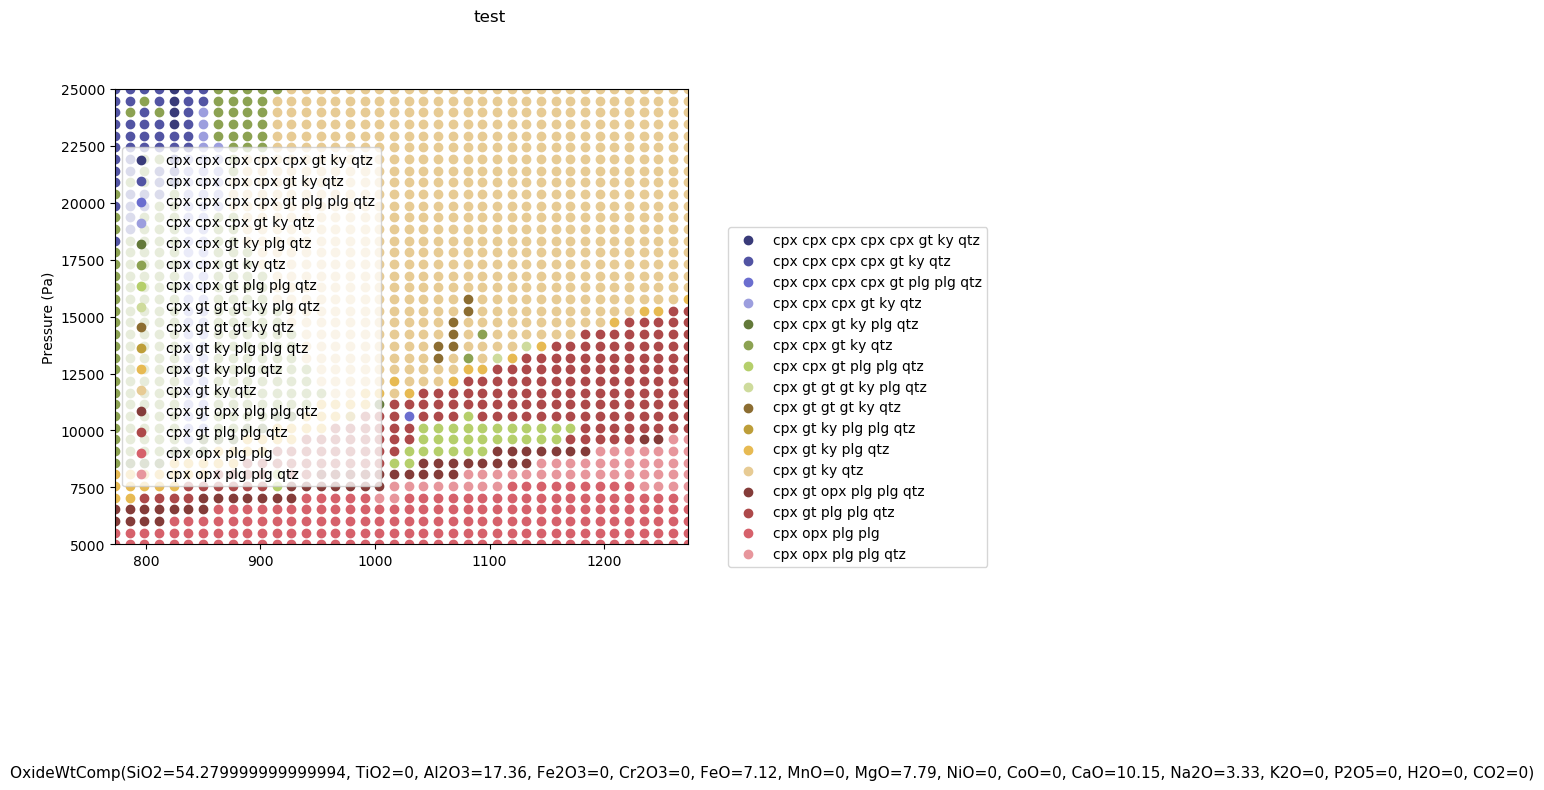

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import collections
collections.MutableSequence = collections.abc.MutableSequence

#from __future__ import annotations # Enable Python 4 type hints in Python 3
from thermoengine.equilibrate import PhaseLibrary, GibbsMinimizer, System
import thermoengine as thermo
from thermoengine.const import units
from thermoengine.core import UnorderedList
import os
import contextlib
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys

sys.path.append(os.path.join(os.path.pardir, 'database', 'install','tcg_slb_database','lib','python3.9','site-packages')) # the final slash is necessary!
import py_tcg_slb_database as tcgdb
stixrudeDB = thermo.model.Database.from_thermocodegen(tcgdb)

def supress_stdout(func):
    def wrapper(*a, **ka):
        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                return func(*a, **ka)
    return wrapper

@supress_stdout
def update_system(sys,T,P, comp=None, phase_library=None):
    if sys is None:
        assert(comp is not None)
        assert(phase_library is not None)
        sys = System(
            T=800,
            P=0.25*units.GPA,
            comp=comp,
            options={'grid_spacing':0.2},
            phase_library=phase_library,
        )
    sys.update(T=T, P=P)
    return sys

def run(phase_symbols = None, oxides = None, T=None, P=None, name=None, database="Berman"):

    phase_symbols_berman =  [
        "Qz", "Coe",
        "Grt",  
        'Di','Jd','cEn', #'Cpx'
        'En', 'Fs',
        "Ky",
        "Ab", "An",
        "Rt",
        "Mc"
    ]

    phase_symbols_stixrude = [
        "Qz",
        "Grt",  
        "Cpx",
        "Opx",
        "Ky",
        "Fsp",
    ]

    phase_symbols_stixrude_tcg = [
        "qtz",
        "gt",  
        "cpx",
        "opx",
        "ky",
        "plg",
    ]

    phase_abbrev_list = phase_symbols_berman if database == "Berman" and phase_symbols is None else phase_symbols
    phase_abbrev_list = phase_symbols_stixrude if database == "Stixrude" and phase_symbols is None else phase_symbols
    phase_abbrev_list = phase_symbols_stixrude_tcg if database is not None and phase_symbols is None else phase_symbols


    assert(name is not None)
    assert(P is not None)
    assert(T is not None)
    assert(oxides is not None)
    assert(phase_abbrev_list is not None)
    
    Tmin = np.amin(T)
    Tmax = np.amax(T)
    Pmin = np.amin(P)
    Pmax = np.amax(P)

    oxide_comp = thermo.OxideWtComp(**oxides)

    db = thermo.model.Database(database=database) if database == "Berman"  else stixrudeDB
    phases = db.get_phases(phase_abbrev_list)
    phase_library = PhaseLibrary(phases)

    system = update_system(
            None,
            T=800,
            P=0.25*units.GPA,
            comp=oxide_comp,
            phase_library=phase_library,
        )

    Ts, Ps = np.meshgrid(T,P)

    comps = np.empty(Ts.shape, dtype='U32')
    energy = np.empty(Ts.shape, dtype='float')
    assemblages = np.empty(Ts.shape, dtype='object')
    
    for j,t in enumerate(T):
        for i,p in enumerate(P):
            update_system(system, t,p)
            names = system.stable_assemblage.names[system.stable_assemblage.amounts>0.001]
            hash = " ".join(sorted(names))
            comps[i][j] = hash
            energy[i][j] = system.stable_assemblage.total_energy
            assemblages[i][j] = system.stable_assemblage

    try:
        plot_result(system,Ts,Ps,assemblages,name+"_"+database)
    except Exception as e: print(e)

    return [Ts, Ps, assemblages, system]

def plot_result(system,Ts,Ps,assemblages,title):
    
    get_hash = lambda assemblage : " ".join(sorted(assemblage.names[assemblage.amounts>0.001]))
    get_n_phases = lambda s: len(s.split())

    comps = np.vectorize(get_hash)(assemblages)

    n_phases = np.vectorize(get_n_phases)(comps)

    Tmin = np.amin(Ts)
    Tmax = np.amax(Ts)
    Pmin = np.amin(Ps)
    Pmax = np.amax(Ps)

    categories = np.unique(comps).flatten()
    colormap = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20)), plt.cm.tab20c(np.linspace(0, 1, 20))))
    colorLookup = dict([(key, value) for key, value in zip(categories, colormap)])
    colors = [colorLookup[c] for c in comps.flatten()]

    shape = (comps.shape[0], comps.shape[1], 4)
    colorgrid = np.reshape(colors, shape)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot(4,4,(1,11))

    for q,cat in enumerate(categories):
        indx = comps.flatten() == cat
        ax1.scatter(Ts.flatten()[indx], Ps.flatten()[indx], label=cat, color=colorLookup[cat])
        
    plt.xlim([Tmin,Tmax])
    plt.ylim([Pmin,Pmax])
    plt.ylabel("Pressure (Pa)")
    ax1.legend(loc='center left')

    ax3 = plt.subplot(4,4,(4,16))
    ax3.legend(*ax1.get_legend_handles_labels(), loc='center left')
    #ax1.get_legend().remove()
    #ax1.remove()
    ax3.axis('off')

    #ax2 = plt.subplot(4,4,(1,11))
    #ax2.imshow(n_phases, cmap="Blues", origin='lower', extent=(Tmin,Tmax,Pmin/units.GPA,Pmax/units.GPA), aspect="auto")
    #ax2.imshow(colorgrid, origin='lower', extent=(Tmin,Tmax,Pmin/units.GPA,Pmax/units.GPA), aspect="auto")
    #plt.ylabel("Pressure (GPa)")
    #plt.xlabel("Temperature (K)")

    fig.suptitle(title)
    text = system.comp
    plt.gcf().text(0.02, 0.02, str(system.comp), fontsize=11)
    plt.savefig(title + "_"+ dt.datetime.now().isoformat() + ".png",facecolor='white', transparent=False)

plot_result(system,Ts, Ps, assemblages, 'test')

In [ ]:
system.comp
names = system.stable_assemblage.names
ms = system.stable_assemblage.amounts
ems = system.stable_assemblage.sample_endmem_comps

nameToM = {}
nameToEndmemberToC = {}

for i,name in enumerate(names):
    nameToM[name] = ms[i]
    #nameToEndmemberToC[name] = 


# write results to dict
# that can be dumped to json and read by TCG
results = {
    "T":T,
    "P":P,
    "comp":system.stable_assemblage,
    "mi0": "......"
}



In [ ]:
system.summary.report()

TypeError: 'list' object is not callable

In [ ]:
system.stable_assemblage.sample_endmem_comps

array([array([1.]), array([0.4, 0.4, 0.2, 0. , 0. ]),
       array([0.5, 0.2, 0.1, 0. , 0.2]), array([0.9, 0.1]),
       array([0.        , 0.25971214, 0.34028786, 0.        , 0.4       ])],
      dtype=object)

In [ ]:
system.stable_assemblage.elem_comps

,O,Na,Mg,Al,Si,Ca,Fe
Qz,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
Grt,0.600000,0.000000,0.060000,0.100000,0.150000,0.030000,0.060000
Cpx,0.600000,0.020000,0.070000,0.020000,0.200000,0.070000,0.020000
Fsp,0.615385,0.007692,0.000000,0.146154,0.161538,0.069231,0.000000
Cpx,0.600000,0.040000,0.068058,0.040000,0.200000,0.025971,0.025971
